<a href="https://colab.research.google.com/github/WellingtonLandim/wellingtonlandim.github.io/blob/main/Classifica%C3%A7%C3%A3o/Cassifica%C3%A7%C3%A3o_de_Imagens_com_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [22]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    59    0    59    0     0    304      0 --:--:-- --:--:-- --:--:--   305
 archive.zip		      save_at_14.keras	 save_at_25.keras
 CDLA-Permissive-2.0.pdf      save_at_15.keras	 save_at_2.keras
 DSC_0082.JPG		      save_at_16.keras	 save_at_3.keras
 kagglecatsanddogs_5340.zip   save_at_17.keras	 save_at_4.keras
 model.png		      save_at_18.keras	 save_at_5.keras
 PetImages		      save_at_19.keras	 save_at_6.keras
'readme[1].txt'		      save_at_1.keras	 save_at_7.keras
 sample_data		      save_at_20.keras	 save_at_8.keras
 save_at_10.keras	      save_at_21.keras	 save_at_9.keras
 save_at_11.keras	      save_at_22.keras	'vehicledetection?dataset_version_number=3'
 save_at_12.keras	      save_at_23.keras
 save_at_13.keras	      save_at_24.keras


In [23]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

[archive.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of archive.zip or
        archive.zip.zip, and cannot find archive.zip.ZIP, period.
 archive.zip		      save_at_14.keras	 save_at_25.keras
 CDLA-Permissive-2.0.pdf      save_at_15.keras	 save_at_2.keras
 DSC_0082.JPG		      save_at_16.keras	 save_at_3.keras
 kagglecatsanddogs_5340.zip   save_at_17.keras	 save_at_4.keras
 model.png		      save_at_18.keras	 save_at_5.keras
 PetImages		      save_at_19.keras	 save_at_6.keras
'readme[1].txt'		      save_at_1.keras	 save_at_7.keras
 sample_data		      save_at_20.keras	 save_at_8.keras
 save_at_10.keras	      save_at_21.keras	 save_at_9.keras
 save_at_11.keras	      save_at_22.keras	'vehicledetection?dataset_version_number=3'
 save_a

In [4]:
!ls PetImages

Cat  Dog


In [5]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [8]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


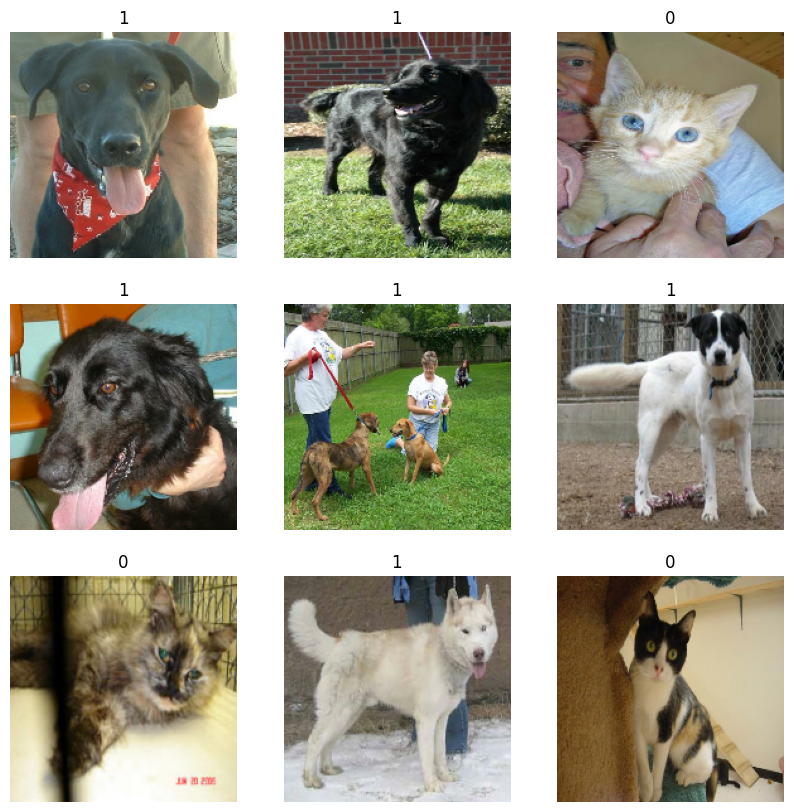

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [10]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

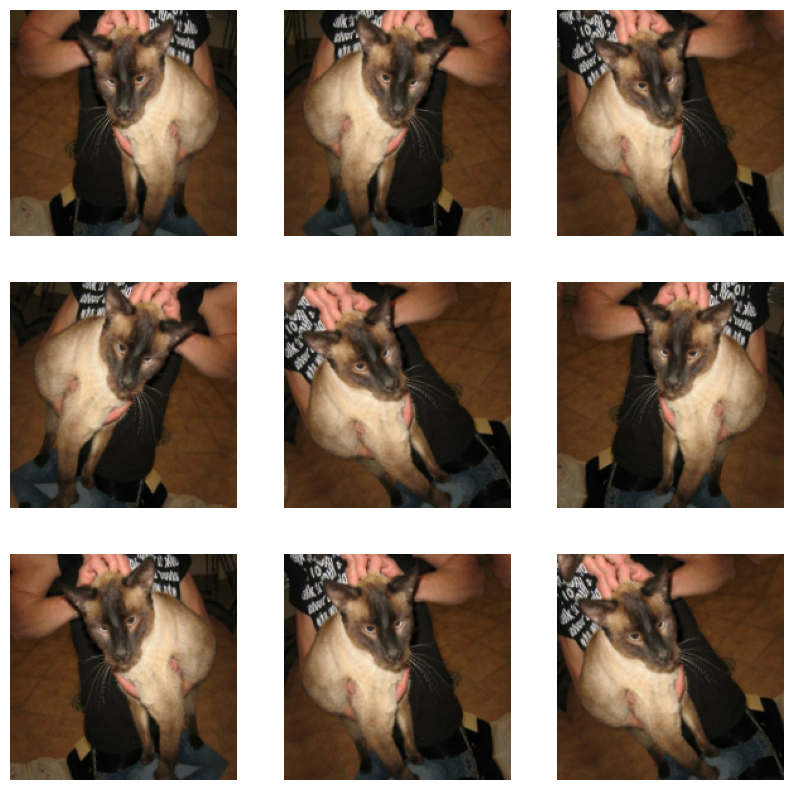

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [12]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

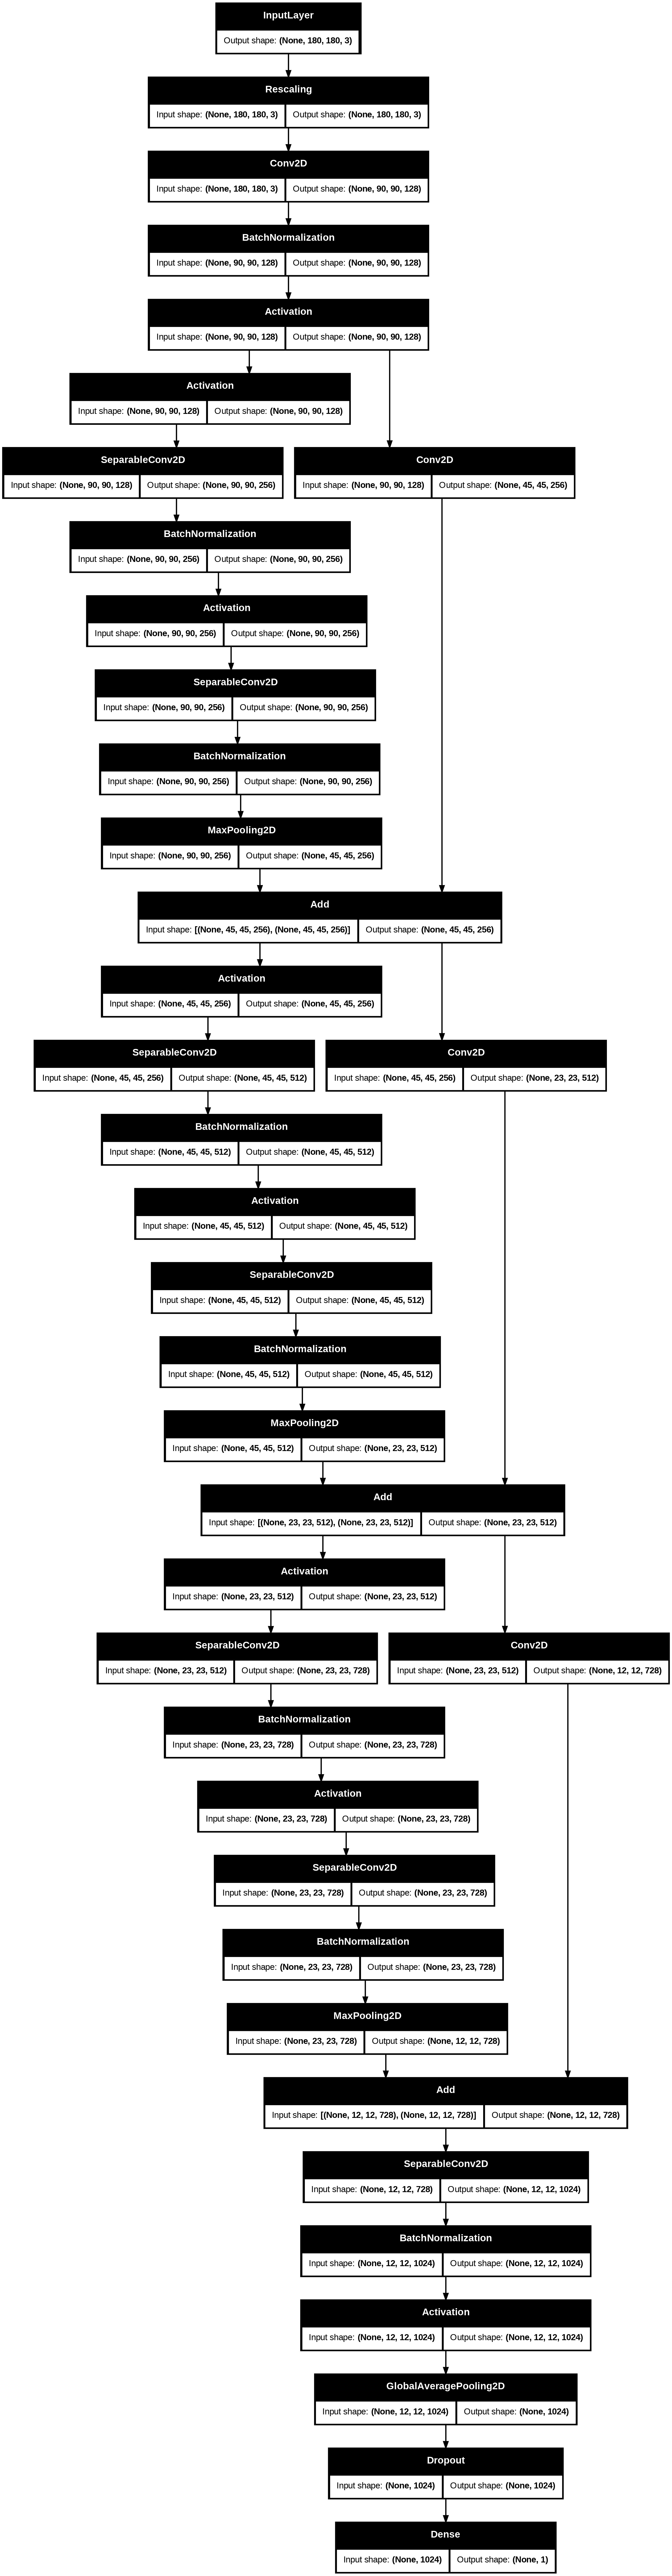

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [14]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - acc: 0.6270 - loss: 0.6385 - val_acc: 0.4957 - val_loss: 0.6937
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - acc: 0.7474 - loss: 0.4962 - val_acc: 0.4957 - val_loss: 0.6950
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - acc: 0.8120 - loss: 0.3958 - val_acc: 0.4957 - val_loss: 0.6859
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - acc: 0.8454 - loss: 0.3403 - val_acc: 0.4957 - val_loss: 0.9724
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - acc: 0.8675 - loss: 0.2982 - val_acc: 0.6294 - val_loss: 0.6371
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - acc: 0.8886 - loss: 0.2572 - val_acc: 0.6754 - val_loss: 0.5829
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - acc: 0.8963 - loss: 0.2343 - val_acc: 0.9003 - val_loss: 0.2643
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - acc: 0.9111 - loss: 0.2060 - val_acc: 0.8896 - val_loss: 0.2383
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image is 11.07% cat and 88.93% dog.


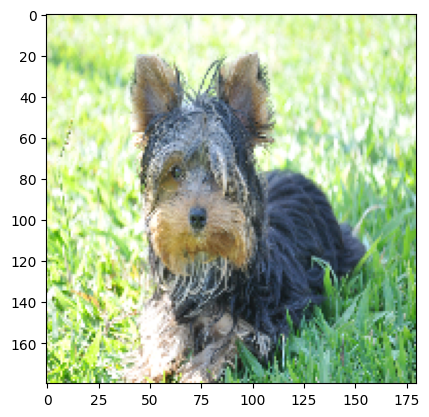

In [17]:
img = keras.utils.load_img("/content/DSC_0082.JPG", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")